In [175]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [176]:
import requests
import re
import os
import zipfile
import collections
import urllib.request
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
from collections import defaultdict
import time
import random
import tqdm
from itertools import groupby
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw
import pickle

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


In [177]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.11.0
keras version 2.11.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Reading the data

In [178]:
%%capture
# !unzip "./all_data/sep_1/data.zip" -d "./temp_data/sep_1/"

In [180]:
# Getting the folder names 
folder_names_1 = glob.glob("./temp_data/sep_1/data/*")
folder_names_2 = glob.glob("./temp_data/sep_0.7/data/*")
# folder_names = folder_names_1 + folder_names_2
folder_names = folder_names_1
# folder_names = folder_names_2

In [181]:
# Getting the data names
data_names = []
for i in folder_names:
    data_names.append(glob.glob(i+"/*.csv"))

## Data Loading

In [182]:
# Datasets to skip 
skip = []

# Labels of the datasets
labels = []

# Data list 
data = []


# Getting the labels and data for each dataset
for i in range(len(data_names)):
    if i in skip:
        continue
    
    for j in range(len(data_names[i])):
        labels.append([data_names[i][j][data_names[i][j].find(".csv")-1]])
        
        # Cleaning data
        df = pd.read_csv(data_names[i][j],skiprows = 1)
        df.drop(columns=df.columns[-1], axis=1,  inplace=True)
        
        data.append(df)

In [183]:
# Changing the labels from int to string
labels = [int(i)-1 for i in np.reshape(labels,(-1,))]

In [184]:
# Targets for sep_1
target = np.array([[-0.314,1.661,0.45],[0,1.661,0.45],[0.314,1.661,0.45],[-0.314,1.347,0.45],[0,1.347,0.45],[0.314,1.347,0.45],[-0.314,1.033,0.45],[0,1.033,0.45],[0.314,1.033,0.45]])

## Adding Features

In [185]:
# Adding the centroid of all the fingers to the data

new_data = []

for idx_1 in range(len(data)):

    
    # Grouped columns for centroid
    grouped_columns_x = data[idx_1].columns[3::3] 
    grouped_columns_y = data[idx_1].columns[4::3]
    grouped_columns_z = data[idx_1].columns[5::3]
    
    # Getting the centroid of the finger points
    cent_x = np.mean(data[idx_1][grouped_columns_x],axis = 1)
    cent_y = np.mean(data[idx_1][grouped_columns_y],axis = 1)
    cent_z = np.mean(data[idx_1][grouped_columns_z],axis = 1)
    
    new_data.append(pd.concat([data[idx_1],cent_x,cent_y,cent_z],axis = 1))
    

## Data Cleaning

In [186]:
# Pulling only the centroid data 
cent_data = [i.iloc[:,-3:] for i in new_data]

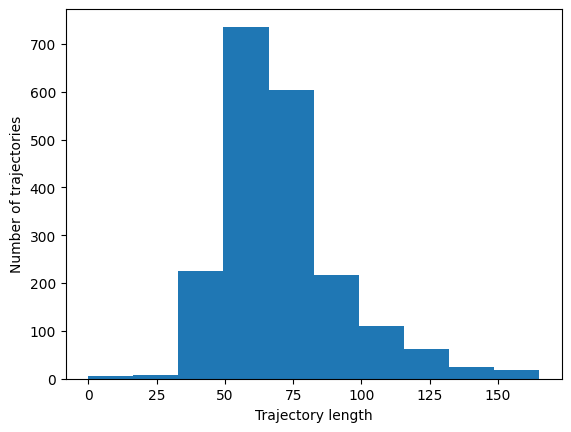

In [187]:
lengths = np.array([len(i) for i in cent_data])
plt.hist(lengths)
plt.xlabel("Trajectory length")
plt.ylabel("Number of trajectories");

In [188]:
# Getting the mean trajectory lengths
np.mean(lengths)

70.61878727634195

In [189]:
# Removing trajectories with <=5 length
idx = np.where(lengths <= 13.)[0]
[labels.pop(j-i) for i,j in enumerate(idx)]
[cent_data.pop(j-i) for i,j in enumerate(idx)];

In [190]:
# Checking to see if it worked 
lengths = np.array([len(i) for i in cent_data])
np.where(lengths <= 13.)

(array([], dtype=int64),)

In [191]:
# For target point prediction
data_3d = []
target_3d = []
for i in cent_data:
    data_3d.append(i.iloc[:-10,:])
    temp = []
    for j in range(len(i.iloc[:-10,:])):
        temp.append(i.iloc[j+1:j+11,:])
    target_3d.append(temp)

## Splitting the data into training and testing

In [192]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(cent_data, labels, test_size=0.2, random_state = 7)
# x_train_, x_test_, y_train_, y_test_ = train_test_split(data_3d, target_3d, test_size=0.2, random_state = 7)

## Data Formatting

In [97]:
# Getting the data in the required format for the model
# Creating labels for RNN's output 
y_train = [[dt]*200 for idx,dt in enumerate(y_train)]
y_test = [[dt]*200 for idx,dt in enumerate(y_test)]

In [98]:
# Sequence length is based on data analysis
# x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train_, padding='post', dtype='float', maxlen=200, value = -10.))
x_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', dtype='float', maxlen=200, value = 0))
# y_train = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_train_, padding='post', dtype='float', maxlen=200))
y_train = tf.convert_to_tensor(y_train)

# x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test_, padding='post', dtype='float', maxlen=200, value = -10.))
x_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', dtype='float', maxlen=200, value = 0))
# y_test = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(y_test_, padding='post', dtype='float', maxlen=200))
y_test = tf.convert_to_tensor(y_test)

In [99]:
# One hot encoding the data for training - not required for label_3d
y_train = tf.one_hot(y_train, 9, on_value = 1.0, off_value = 0.0)
y_test = tf.one_hot(y_test, 9, on_value = 1.0, off_value = 0.0)

## Models

### Creating the DTW model

In [200]:
def model_dtw(ip_data,op_data):
    data_dict_x = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
    data_dict_y = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
    data_dict_z = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}

    time = np.arange(len(ip_data))
    for i,j in zip(ip_data,op_data):

        time = np.arange(len(i))
        
        data_dict_x[j].append(np.polyfit(time,i[0],3))
        data_dict_y[j].append(np.polyfit(time,i[1],3))
        data_dict_z[j].append(np.polyfit(time,i[2],3))

    # getting the mean and trend
    trend_dict_x = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
    trend_dict_y = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
    trend_dict_z = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[]}
    time = np.arange(70)
    for i in range(9):
        trend_dict_x[i] = np.poly1d(np.mean(data_dict_x[i],axis = 0))(time)
        trend_dict_y[i] = np.poly1d(np.mean(data_dict_y[i],axis = 0))(time)
        trend_dict_z[i] = np.poly1d(np.mean(data_dict_z[i],axis = 0))(time)

  
    dict_q = []
    for i in range(9):
        dict_q.append(np.array([trend_dict_x[i],trend_dict_y[i],trend_dict_z[i]]))
    return dict_q


def model_dtw_pred(ip_data,dic):

    
    predi = []
#     for k in range(0,len(ip_data)):
    d = []
    for i in range(0,9):
        distance, path = fastdtw(dic[i].T, ip_data, dist=euclidean)
        d.append(distance)

    predi.append(d.index(min(d)))
    
    return predi

In [201]:
dict_q = model_dtw(x_train,y_train)
with open("./models/sep_1/data_driven", 'wb') as handle:
    pickle.dump(dict_q, handle, protocol=pickle.HIGHEST_PROTOCOL)
# Load data (deserialize)
with open('./models/sep_1/data_driven', 'rb') as handle:
    dic = pickle.load(handle)
predi = model_dtw_pred(x_test[0],dict_q)

In [202]:
predi

[7]

### Creating the LSTM model

In [21]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h)

model_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the LSTM model - labels_3d

In [22]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

masking = tf.keras.layers.Masking(mask_value=-10.)
masked_op = masking(seq_input)

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(masked_op)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h = LSTM(ip_reformed)

dense = tf.keras.layers.Dense(30, activation='linear')
dense_out = dense(h)

reshaping = tf.keras.layers.Reshape((200,10, 3))
output = reshaping(dense_out)

model_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_LSTM_3d.compile(loss='mse', metrics = ['mae'],optimizer=Adam(1e-2))

### Creating the LSTM+RNN model

In [23]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(seq_input)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(9, activation='softmax')
output = dense(h_2)

model_RNN_LSTM = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM.compile(loss='categorical_crossentropy', metrics = ['accuracy'], optimizer=Adam(1e-2))

### Creating the LSTM+RNN model - labels_3d

In [20]:
hidden_size= 15
tf.keras.backend.clear_session()
seq_input = tf.keras.Input(shape=x_train.shape[1:], name='input_layer')

masking = tf.keras.layers.Masking(mask_value=-10.)
masked_op = masking(seq_input)

ip_reform = tf.keras.layers.Dense(hidden_size)

ip_reformed = ip_reform(masked_op)

RNN = tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)
h_1 = RNN(ip_reformed)

LSTM = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h_2 = LSTM(h_1)

dense = tf.keras.layers.Dense(30, activation='linear')
dense_out = dense(h_2)

reshaping = tf.keras.layers.Reshape((200,10, 3))
output = reshaping(dense_out)

model_RNN_LSTM_3d = tf.keras.models.Model(inputs=seq_input, outputs=output)

model_RNN_LSTM_3d.compile(loss='mse', metrics = ['mae'], optimizer=Adam(1e-2))

In [21]:
model_RNN_LSTM_3d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 masking (Masking)           (None, 200, 3)            0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 15)           465       
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 30)           480       
                                                                 
 reshape (Reshape)           (None, 200, 10, 3)        0     

In [22]:
# callbacks = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=100,
#     restore_best_weights = True
# )

callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=100,
    restore_best_weights = True
)

In [23]:
history = model_RNN_LSTM_3d.fit(x_train,y_train, epochs=1000, batch_size=16, validation_split=0.2,callbacks = [callbacks])

Epoch 1/1000


2022-12-13 16:35:11.906640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2022-12-13 16:35:14.020076: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x14a091c54b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-13 16:35:14.020095: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2022-12-13 16:35:14.103729: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-13 16:35:14.610576: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/116 [==============================] - 34s 149ms/step - loss: 0.0109 - mae: 0.0405 - val_loss: 0.0021 - val_mae: 0.0182
Epoch 2/1000
116/116 [==============================] - 16s 139ms/step - loss: 0.0014 - mae: 0.0148 - val_loss: 9.0127e-04 - val_mae: 0.0121
Epoch 3/1000
116/116 [==============================] - 17s 142ms/step - loss: 6.3876e-04 - mae: 0.0100 - val_loss: 7.9560e-04 - val_mae: 0.0119
Epoch 4/1000
116/116 [==============================] - 16s 141ms/step - loss: 5.3815e-04 - mae: 0.0091 - val_loss: 5.1718e-04 - val_mae: 0.0089
Epoch 5/1000
116/116 [==============================] - 17s 142ms/step - loss: 3.3984e-04 - mae: 0.0071 - val_loss: 2.5057e-04 - val_mae: 0.0058
Epoch 6/1000
116/116 [==============================] - 16s 141ms/step - loss: 2.4240e-04 - mae: 0.0058 - val_loss: 3.7125e-04 - val_mae: 0.0076
Epoch 7/1000
116/116 [==============================] - 17s 144ms/step - loss: 2.4036e-04 - mae: 0.0057 - val_loss: 2.9518e-04 - val_mae: 0.0066
Epoch 8/10

116/116 [==============================] - 16s 142ms/step - loss: 5.7049e-05 - mae: 0.0030 - val_loss: 7.0060e-05 - val_mae: 0.0032
Epoch 114/1000
116/116 [==============================] - 16s 139ms/step - loss: 5.1417e-05 - mae: 0.0027 - val_loss: 7.0800e-05 - val_mae: 0.0033
Epoch 115/1000
116/116 [==============================] - 16s 139ms/step - loss: 6.0992e-05 - mae: 0.0030 - val_loss: 1.4356e-04 - val_mae: 0.0051
Epoch 116/1000
116/116 [==============================] - 17s 146ms/step - loss: 6.4520e-05 - mae: 0.0032 - val_loss: 6.5206e-05 - val_mae: 0.0031
Epoch 117/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.9702e-05 - mae: 0.0026 - val_loss: 6.1064e-05 - val_mae: 0.0027
Epoch 118/1000
116/116 [==============================] - 17s 143ms/step - loss: 5.2330e-05 - mae: 0.0028 - val_loss: 6.4438e-05 - val_mae: 0.0031
Epoch 119/1000
116/116 [==============================] - 17s 143ms/step - loss: 5.1707e-05 - mae: 0.0027 - val_loss: 5.6812e-05 - va

Epoch 169/1000
116/116 [==============================] - 17s 143ms/step - loss: 5.8084e-05 - mae: 0.0030 - val_loss: 6.5414e-05 - val_mae: 0.0029
Epoch 170/1000
116/116 [==============================] - 17s 147ms/step - loss: 5.3914e-05 - mae: 0.0027 - val_loss: 7.1059e-05 - val_mae: 0.0030
Epoch 171/1000
116/116 [==============================] - 16s 142ms/step - loss: 6.0457e-05 - mae: 0.0031 - val_loss: 6.1493e-05 - val_mae: 0.0026
Epoch 172/1000
116/116 [==============================] - 17s 143ms/step - loss: 5.7303e-05 - mae: 0.0029 - val_loss: 6.6400e-05 - val_mae: 0.0030
Epoch 173/1000
116/116 [==============================] - 17s 146ms/step - loss: 5.6105e-05 - mae: 0.0029 - val_loss: 8.6536e-05 - val_mae: 0.0038
Epoch 174/1000
116/116 [==============================] - 16s 141ms/step - loss: 6.1712e-05 - mae: 0.0032 - val_loss: 6.6812e-05 - val_mae: 0.0030
Epoch 175/1000
116/116 [==============================] - 17s 145ms/step - loss: 5.6297e-05 - mae: 0.0030 - val_loss: 

Epoch 225/1000
116/116 [==============================] - 17s 146ms/step - loss: 5.0023e-05 - mae: 0.0027 - val_loss: 5.3405e-05 - val_mae: 0.0022
Epoch 226/1000
116/116 [==============================] - 17s 146ms/step - loss: 4.6332e-05 - mae: 0.0025 - val_loss: 6.4839e-05 - val_mae: 0.0030
Epoch 227/1000
116/116 [==============================] - 17s 145ms/step - loss: 5.8126e-05 - mae: 0.0030 - val_loss: 5.7315e-05 - val_mae: 0.0027
Epoch 228/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.7968e-05 - mae: 0.0026 - val_loss: 6.4354e-05 - val_mae: 0.0031
Epoch 229/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.8291e-05 - mae: 0.0027 - val_loss: 5.5527e-05 - val_mae: 0.0027
Epoch 230/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.6498e-05 - mae: 0.0026 - val_loss: 5.5868e-05 - val_mae: 0.0026
Epoch 231/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.8781e-05 - mae: 0.0027 - val_loss: 

Epoch 281/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.2367e-05 - mae: 0.0023 - val_loss: 5.2948e-05 - val_mae: 0.0027
Epoch 282/1000
116/116 [==============================] - 17s 143ms/step - loss: 4.2936e-05 - mae: 0.0024 - val_loss: 6.8119e-05 - val_mae: 0.0034
Epoch 283/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.6307e-05 - mae: 0.0026 - val_loss: 6.8442e-05 - val_mae: 0.0033
Epoch 284/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.4131e-05 - mae: 0.0025 - val_loss: 5.3847e-05 - val_mae: 0.0025
Epoch 285/1000
116/116 [==============================] - 17s 143ms/step - loss: 4.7642e-05 - mae: 0.0027 - val_loss: 6.6877e-05 - val_mae: 0.0032
Epoch 286/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.5975e-05 - mae: 0.0026 - val_loss: 5.2608e-05 - val_mae: 0.0024
Epoch 287/1000
116/116 [==============================] - 17s 148ms/step - loss: 4.4287e-05 - mae: 0.0024 - val_loss: 

Epoch 337/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.3794e-05 - mae: 0.0025 - val_loss: 4.8674e-05 - val_mae: 0.0023
Epoch 338/1000
116/116 [==============================] - 17s 144ms/step - loss: 4.1735e-05 - mae: 0.0024 - val_loss: 5.8282e-05 - val_mae: 0.0030
Epoch 339/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.1614e-05 - mae: 0.0024 - val_loss: 4.9245e-05 - val_mae: 0.0023
Epoch 340/1000
116/116 [==============================] - 17s 147ms/step - loss: 3.9317e-05 - mae: 0.0022 - val_loss: 4.6532e-05 - val_mae: 0.0022
Epoch 341/1000
116/116 [==============================] - 17s 147ms/step - loss: 4.2143e-05 - mae: 0.0024 - val_loss: 5.0435e-05 - val_mae: 0.0026
Epoch 342/1000
116/116 [==============================] - 17s 145ms/step - loss: 4.2211e-05 - mae: 0.0024 - val_loss: 5.2228e-05 - val_mae: 0.0024
Epoch 343/1000
116/116 [==============================] - 17s 146ms/step - loss: 4.3060e-05 - mae: 0.0025 - val_loss: 

In [21]:
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5")
# model_LSTM.save("/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5")
model_RNN_LSTM_3d.save("./models/traj_point/lstm_rnn.h5")

NameError: name 'model_RNN_LSTM_3d' is not defined

## Testing the saved models

In [104]:
# classification models
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm_data_trim.h5')
# model_load = load_model('/content/drive/MyDrive/Robot perception /Modeling/models/lstm.h5')
model_load = load_model('./models/sep_0.7/lstm_rnn.h5')


# 3d models
# model_load = load_model('./models/traj_point/lstm_rnn.h5')



In [105]:
model_load.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 3)]          0         
                                                                 
 dense (Dense)               (None, 200, 15)           60        
                                                                 
 simple_rnn (SimpleRNN)      (None, 200, 15)           465       
                                                                 
 lstm (LSTM)                 (None, 200, 15)           1860      
                                                                 
 dense_1 (Dense)             (None, 200, 9)            144       
                                                                 
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
_________________________________________________________________


## Model evaluation

In [106]:
model_load.evaluate(x_test,y_test)

6/6 [==============================] - 1s 18ms/step - loss: 0.2631 - accuracy: 0.9007


[0.26308029890060425, 0.900730311870575]

In [107]:
model_load.evaluate(x_train,y_train)

23/23 [==============================] - 0s 18ms/step - loss: 0.2674 - accuracy: 0.8985


[0.267398864030838, 0.898490846157074]

In [50]:
# Getting the lengths of x_test
# lengths = np.array([len(i) for i in x_test_])
# Removing trajectories with <=12 length
# idx = np.where(lengths <= 12)[0]
# [y_test_.pop(j-i) for i,j in enumerate(idx)]
# [x_test_.pop(j-i) for i,j in enumerate(idx)];
# Checking
# np.where(lengths <= 12)[0]

# dict_l = defaultdict(list)

# for i in tqdm.tqdm(range(max(lengths)-9)):
#     idx = np.where(lengths >= i+12)[0]
#     x_ = [x_test_[l].values.tolist()[:i+2] for l in idx]
#     y_ = [y_test_[l].values.tolist()[i+2:i+12] for l in idx]
#     if len(idx) == 1:
#             break
#     for k in range(10):

#         temp = tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences(x_, padding='post', dtype='float', maxlen=200, value = -10))

#         preds = model_load.predict(temp, verbose = 0)
#         preds = preds[:,-1,:]
#         [x_[j].append(list(preds[j])) for j in range(len(idx))]
#     print(np.array(x_[j])[i+2:] - np.array(y_[j]))
#     print(np.array(x_[j]))
#     print(np.array(y_[j]))
#     helo
#     [dict_l[i+2].append(np.mean(np.linalg.norm(),axis =0)) for j in range(len(x_))]
# [np.mean(dict_l[i]) for i in dict_l.keys()]           